<a href="https://colab.research.google.com/github/ArturGrigo/ArturGrigo/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача: создать прогностическую модель рисков беременных.

Срок: до 1 недели

Метрика: на выбор

Как сдавать: ссылку на google colab с выводами.

Обязательно вывести матрицу ошибок на тесте.



## Описание признаков:

Age: возраст в годах, когда женщина беременна.

SystolicBP: Верхнее значение артериального давления в мм рт.ст., еще один важный атрибут во время беременности.

DiastolicBP: более низкое значение артериального давления в мм рт.ст., еще один важный признак во время беременности.

BS: Уровень глюкозы в крови выражается в молярной концентрации, ммоль/л.

HeartRate: нормальная частота пульса в состоянии покоя в ударах в минуту.

Risk Level: прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего признака.


# Описание и предобработка данных

In [46]:
import warnings
# Отключение всех предупреждений
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import pandas as pd # для таблиц
import seaborn as sns # для графиков
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     cross_val_score)


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler # для приведение к одному масштабу (масштабирование)


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier # модель классификации
from sklearn.linear_model import LogisticRegression # модель классификации
import xgboost as xgb

from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score # объединяющая полноту и точность мера
from sklearn.metrics import accuracy_score

In [47]:
df = pd.read_csv('/content/sample_data/Maternal Health Risk Data Set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [48]:
df.head(3)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk


In [49]:
features_df = df[['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate']]
features_df.corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
Age,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798
SystolicBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108
DiastolicBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867
BodyTemp,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771
HeartRate,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000


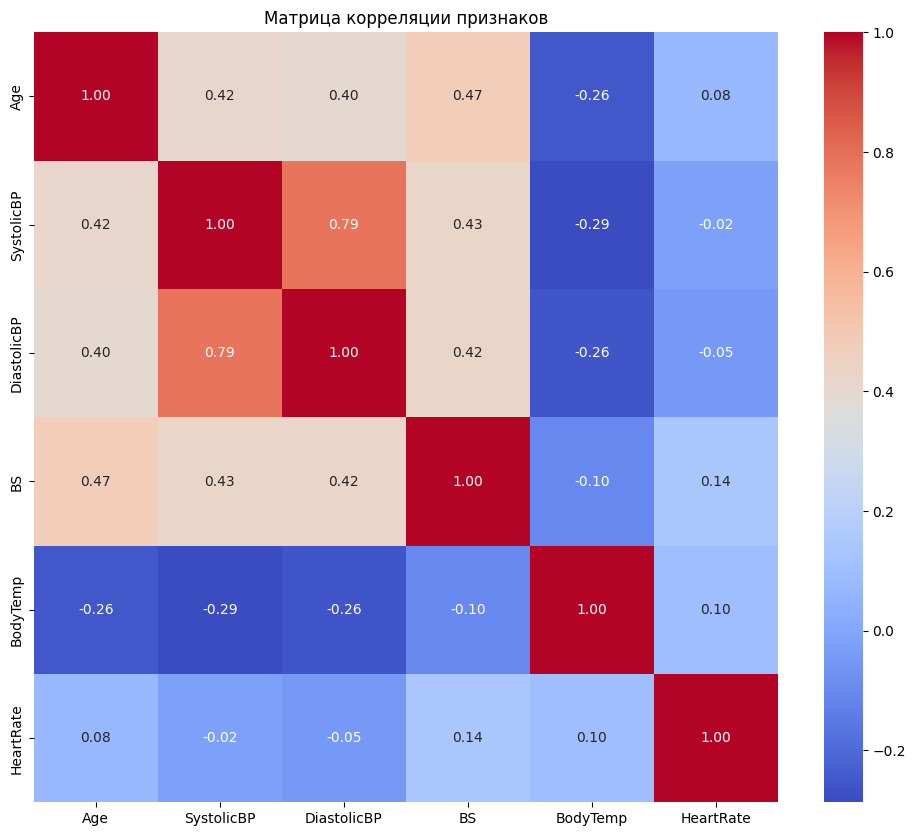

In [50]:
corr_matrix = features_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции признаков')
plt.show()

**Мультиколлинеарность** — корреляция **независимых** переменных, которая затрудняет оценку и анализ общего результата.
В данном случаи таких признаков нет и нужды удалять SystolicBP нет.

In [51]:
# Переименовываем столбцы для удобства работы с мед терминологией
df = df.rename(columns={'Age': 'Возраст', 'SystolicBP': 'вз_артериального_давления', 'DiastolicBP': 'нз_артериального_давления',\
                        'BS': "уровень_глюкозы", 'BodyTemp': 'температура_тела', \
                        'HeartRate': 'частота_пульса', 'RiskLevel': 'уровень_риска_осложнений'})

In [52]:
 #для удобства переведем показатели температуры тела из фарингейта в цельсий
 df['температура_тела_C'] = (df['температура_тела'] - 32) * 5/9
 del df['температура_тела']
 # после тестовых запусков качество модели было лучше, когда
 # она работала с показателем температуры Цельсия °C, а не в Фаренгейта °F,
 # в том числе при условии масштабирования

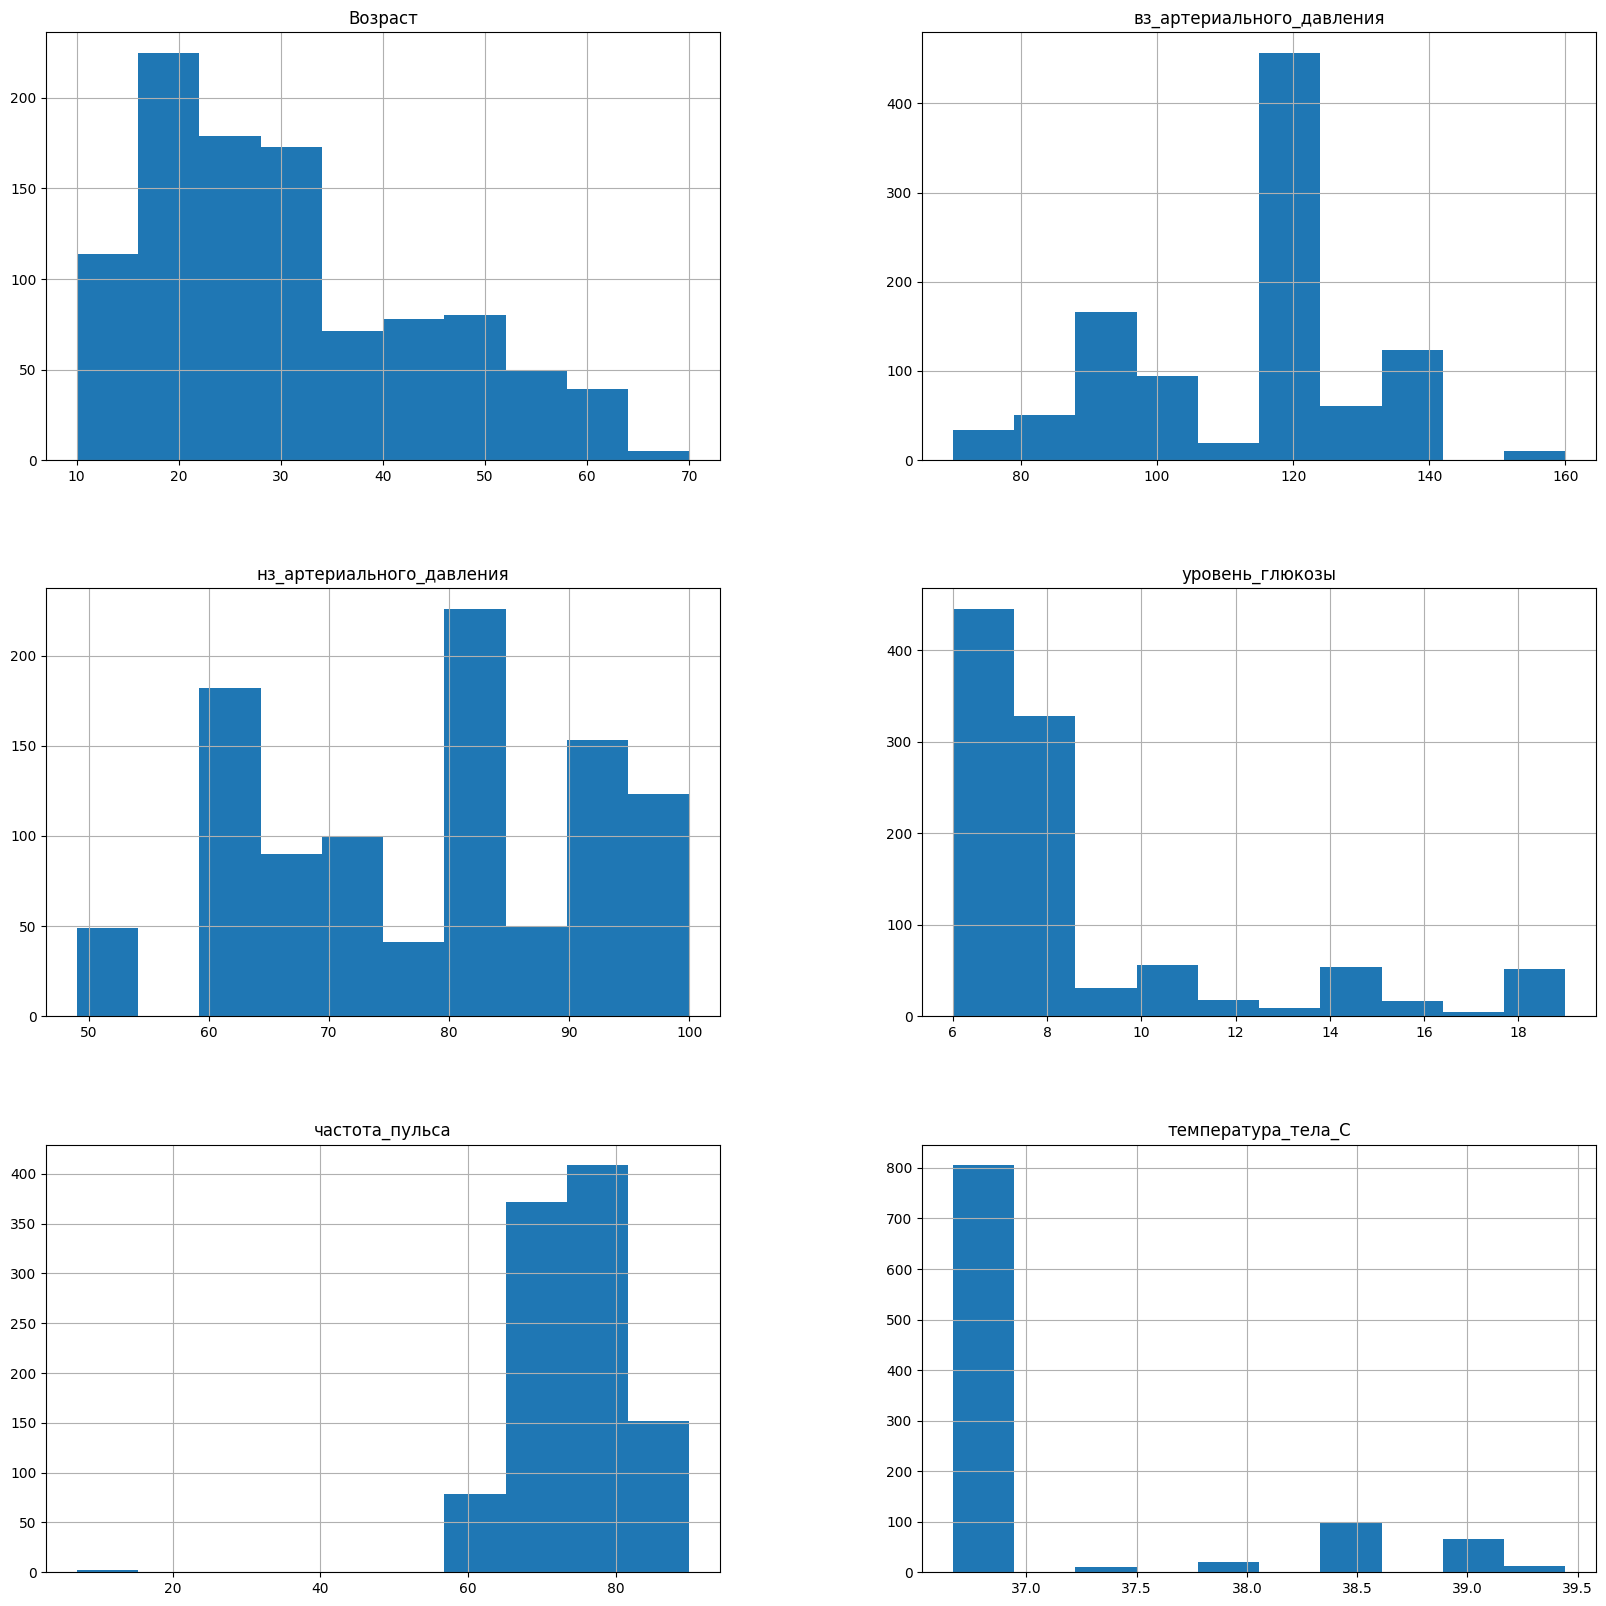

In [53]:
import matplotlib.pyplot as plt
df.hist(figsize=(20,20))
plt.show()

### Исходя из первичного наблюдения и анализа сделаем выводы:


1.   Датасет не имеет пропусков;
2.   Типы данных опеределены верно;
3. Температура тела определена в фарингейтах;
4. Сильных взаимосвязей между признаками не наблюдается, кроме верхнего и нижнего артериального давления, что естественно;
5. Можем заметить следующие аномальные показатели:

*    частота пульса - в районе 5-10 ударов в минуту у нескольких респондентов
*   аномально маленький возраст , 10-14 лет
*   невероятно высокий уровень глюкозы

Все данные аномальные показатели вызывают сомнения в достоверности информации, будем от некоторых избавляться.






In [54]:
#удалим аномальные значения, которые несопостовимы с реальностью
# пульс меньше 10 не сопостовим с жизнью, а беременность до 14 лет крайне редка и сомнительна
df = df[df['частота_пульса'] >= 10]
df = df[df['Возраст'] >= 14]


**Нормативные** **показатели**:

**Частота** **пульса** от 60 до 80

**Уровень** **глюкозы**  в норме должен быть в следующ. диапазоне 3,3-5,1 ммоль/л

Показатели считается нормальными, если систолическое давление не превышает 140 миллиметров ртутного столба, а диастолическое — 90. Оптимальное давление — 120 на 80, нормальное — 120–129 на 80–84, высоконормальное давление — 130–139 на 85–89.



In [55]:
display(df['частота_пульса'].value_counts().sort_index())
df['температура_тела_C'].value_counts().sort_index()

частота_пульса
60     63
66     79
67     12
68      2
70    263
75     19
76    131
77     92
78     46
80    102
82     19
86     55
88     59
90     19
Name: count, dtype: int64

температура_тела_C
36.666667    780
36.888889      2
37.000000      1
37.222222      8
37.777778     20
38.333333     86
38.888889     51
39.444444     13
Name: count, dtype: int64

In [56]:
display(df['уровень_глюкозы'].value_counts().sort_index())
print('-------------------------')
df['Возраст'].value_counts().sort_index()

уровень_глюкозы
6.00      17
6.10      51
6.30       2
6.40       8
6.50       1
6.60       2
6.70      32
6.80      84
6.90     104
7.00      79
7.01      15
7.10       8
7.20      18
7.50     166
7.60       1
7.70      24
7.80      40
7.90      52
8.00      20
9.00      29
10.00      4
11.00     50
12.00     18
13.00      9
15.00     54
16.00     17
17.00      5
18.00     29
19.00     22
Name: count, dtype: int64

-------------------------


Возраст
14     3
15    60
16    14
17    63
18    19
19    67
20    22
21    38
22    45
23    71
24     3
25    48
26     3
27     9
28    28
29    40
30    30
31    22
32    48
33     5
34     5
35    50
36     4
37     6
38     2
39     4
40    37
41     1
42    23
43     5
44     3
45     9
46     1
48    26
49     9
50    43
51     1
54    12
55    37
56     1
59     2
60    34
62     1
63     2
65     3
66     1
70     1
Name: count, dtype: int64

In [57]:
#посмотрим на некоторые математические значения таблицы
df.describe()

,Возраст,вз_артериального_давления,нз_артериального_давления,уровень_глюкозы,частота_пульса,температура_тела_C
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,30.844953,114.103018,77.113424,8.798699,74.658689,36.999884
std,13.167586,18.288794,13.694686,3.360156,7.444101,0.730094
min,14.000000,70.000000,49.000000,6.000000,60.000000,36.666667
25%,20.000000,100.000000,65.000000,6.900000,70.000000,36.666667
50%,28.000000,120.000000,80.000000,7.500000,76.000000,36.666667
75%,40.000000,120.000000,90.000000,8.000000,80.000000,36.666667
max,70.000000,160.000000,100.000000,19.000000,90.000000,39.444444


Исходя из значений выше, можем заметить что:

1) Уровень глюкозы в среднем на 3,7 моль превышает максимальное значения в норме;

2)Частота пульса, температура тела, артериальное давление у большинства  находятся в норме.

In [58]:
# Посмотрим на целевой признак до удаления аномалий
df['уровень_риска_осложнений'].value_counts()

уровень_риска_осложнений
low risk     385
mid risk     314
high risk    262
Name: count, dtype: int64

**Кодирование целевого признака**

Для преобразования целевого признака с текстовыми значениями в числовой формат (который может быть обработан алгоритмами машинного обучения), ,будем использовать метод кодирования категориальных переменных. В данном случаи, так как у нас не бинарный целевой признак, а состоит из 3-х разных классов, выберем метод кодирования **Label Encoding**


In [59]:
# Инициализируем LabelEncoder
label_encoder = LabelEncoder()

# Применим Label Encoding к столбцу "уровень_риска_осложнений" и заменяем его значения
df['уровень_риска_осложнений'] = label_encoder.fit_transform(df['уровень_риска_осложнений'])


In [60]:
# Посмотрим на целевой признак после удаления аномальных значений
df['уровень_риска_осложнений'].value_counts()

уровень_риска_осложнений
1    385
2    314
0    262
Name: count, dtype: int64

**Дисбаланс?**

Как можем заметить небольшой дисбаланс в классах присутствует, но пока оставим его таковым, не считаю его значительным и критичным для дальнейшей работы.

# Подбор и обучение моделей машиного обучения

## Так как целевой признак имеет 3 значния/класса, то будем использовать следующие методы машинного обучнеия:
**1) Случайный лес (Random Forest**): Random Forest - это ансамблевый метод, который хорошо работает для двоичной и для многоклассовой классификации.

**2) Градиентный бустинг (Gradient Boosting)** -  XGBoost и LightGBM, эффективны для классификации на несколько классов.

**3) Логистическая регрессия** показала крайне низкий показатель - ее опробовали и убрали, точность составляла на уровне угадайки, 0.65

In [61]:
features = df.drop(['уровень_риска_осложнений'], axis=1) # Отберем НЕ ЦЕЛЕВЫЕ признаки
target = df['уровень_риска_осложнений'] # ЦЕЛЕВОЙ ПРИЗНАК

In [62]:
 #создадим тестовую и тренировочную выборку, отведя на тестовую 25%
 features_train, features_test, target_train, target_test = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=33)

## **RandomForestClassifier**

In [63]:
%%time
model_forest = RandomForestClassifier()

# Задаем сетку параметров для подбора
param_grid_f = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Выполняем Grid Search с кросс-валидацией
grid_search_f = GridSearchCV(estimator=model_forest, param_grid=param_grid_f, cv=5, scoring='accuracy')
grid_search_f.fit(features_train, target_train)

# Печать лучших параметров и результатов
print("Лучшие параметры:", grid_search_f.best_params_)
print("Лучшая точность:", grid_search_f.best_score_)

# Оценка точности на тестовом наборе с лучшими параметрами
best_model_f = grid_search_f.best_estimator_
y_pred_best_f = best_model_f.predict(features_test)
accuracy_best = accuracy_score(target_test, y_pred_best_f)
print("Точность на тестовом наборе с лучшими параметрами:", accuracy_best)
f1_2 = f1_score(target_test, y_pred_best_f, average='macro')
print(f"F1-мера модели XGBoost: {f1_2}")

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучшая точность: 0.8111111111111111
Точность на тестовом наборе с лучшими параметрами: 0.8589211618257261
F1-мера модели XGBoost: 0.8618255870904544
CPU times: user 2min 48s, sys: 689 ms, total: 2min 48s
Wall time: 2min 56s


## **XGBClassifier**

In [64]:
%%time
# Создаем модель XGBoost с 3-мя классами
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

# Оптимизация параметров с помощью GridSearchCV
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 250],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
model.set_params(**best_params)

# Использование ранней остановки (early stopping)
model.fit(features_train, target_train, early_stopping_rounds=10, eval_set=[(features_test, target_test)])

# Делаем предсказания на тестовом наборе
y_pred = model.predict(features_test)
print("Лучшие параметры:", grid_search.best_params_)
# качество модели
accuracy = accuracy_score(target_test, y_pred)
print("Точность модели XGBoost после улучшений:", accuracy)
# Расчет F1-меры
f1 = f1_score(target_test, y_pred, average='macro')
print(f"F1-мера модели XGBoost: {f1}")

[0]	validation_0-mlogloss:1.03630
[1]	validation_0-mlogloss:0.99453
[2]	validation_0-mlogloss:0.94443
[3]	validation_0-mlogloss:0.90971
[4]	validation_0-mlogloss:0.87394
[5]	validation_0-mlogloss:0.83192
[6]	validation_0-mlogloss:0.80704
[7]	validation_0-mlogloss:0.77423
[8]	validation_0-mlogloss:0.75147
[9]	validation_0-mlogloss:0.72385
[10]	validation_0-mlogloss:0.69993
[11]	validation_0-mlogloss:0.68254
[12]	validation_0-mlogloss:0.66456
[13]	validation_0-mlogloss:0.64693
[14]	validation_0-mlogloss:0.63150
[15]	validation_0-mlogloss:0.61798
[16]	validation_0-mlogloss:0.60385
[17]	validation_0-mlogloss:0.59393
[18]	validation_0-mlogloss:0.58189
[19]	validation_0-mlogloss:0.57703
[20]	validation_0-mlogloss:0.56935
[21]	validation_0-mlogloss:0.55869
[22]	validation_0-mlogloss:0.54799
[23]	validation_0-mlogloss:0.54146
[24]	validation_0-mlogloss:0.53370
[25]	validation_0-mlogloss:0.52715
[26]	validation_0-mlogloss:0.51890
[27]	validation_0-mlogloss:0.51389
[28]	validation_0-mlogloss:0.5

## **LGBMClassifier**

In [65]:
%%time
import lightgbm as lgb
# Создаем модель LightGBM
model_l = lgb.LGBMClassifier(objective='multiclass', num_class=3)

# Оптимизация параметров с  GridSearchCV
param_grid_l = {
    'max_depth': [ 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7]
}

grid_search_l = GridSearchCV(estimator=model_l, param_grid=param_grid_l, scoring='accuracy', cv=5)
grid_search_l.fit(features_train, target_train)

best_params = grid_search_l.best_params_
model.set_params(**best_params)

# Использование ранней остановки (early stopping)
model.fit(features_train, target_train,  eval_set=[(features_test, target_test)])

# Делаем предсказания на тестовом наборе
y_pred_l = model.predict(features_test)
print("Лучшие параметры:", grid_search_l.best_params_)
accuracy_l = accuracy_score(target_test, y_pred_l)
print("Точность модели LightGBM после улучшений:", accuracy_l)
fl1 = f1_score(target_test, y_pred_l, average='macro')
print(f"F1-мера модели LightGBM: {fl1}")

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [66]:
# Включаем предупреждения обратно
warnings.filterwarnings("default")

In [74]:
data = {
    'Accuracy на тестовой выборке:': [accuracy_l,   0.887, accuracy_best],
    'F1-мера:': [fl1, f1, f1_2],
    'Скорость (время) отработки модели' : ['57.4 s', '46.5 s', '2min 56s' ]
}

data = pd.DataFrame(data, index=['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier'])

print(data)

                        Accuracy на тестовой выборке:  F1-мера:  \
LGBMClassifier                               0.871369  0.874937   
XGBClassifier                                0.887000  0.890597   
RandomForestClassifier                       0.858921  0.861826   

                       Скорость (время) отработки модели  
LGBMClassifier                                    57.4 s  
XGBClassifier                                     46.5 s  
RandomForestClassifier                          2min 56s  


### **Вывод: Лучшее качество и скорость показала модель XGBClassifier**

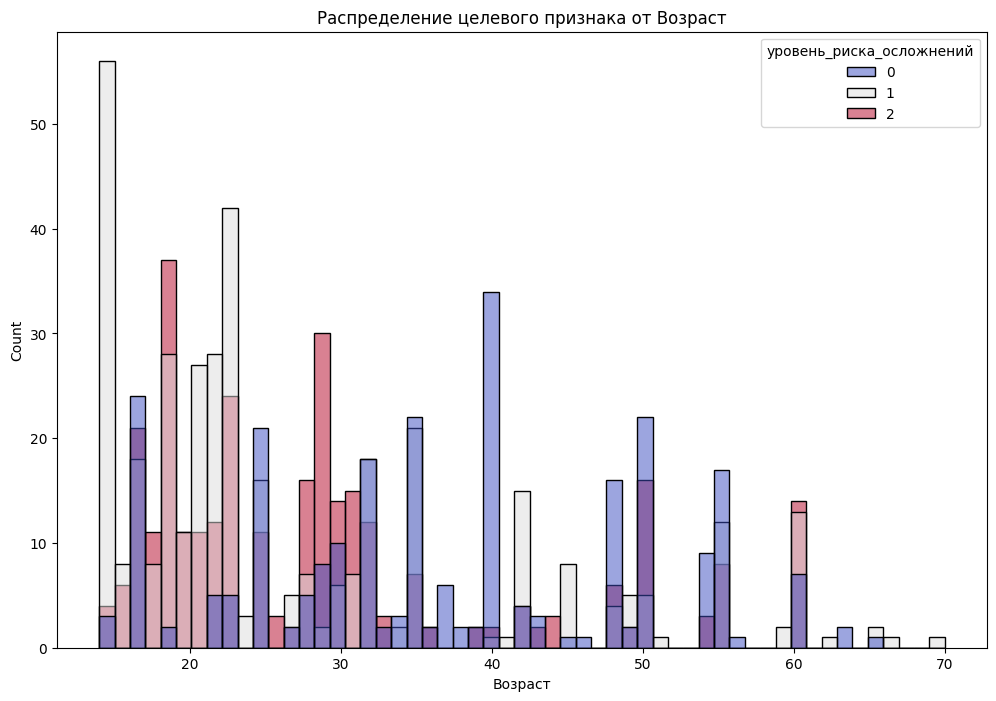

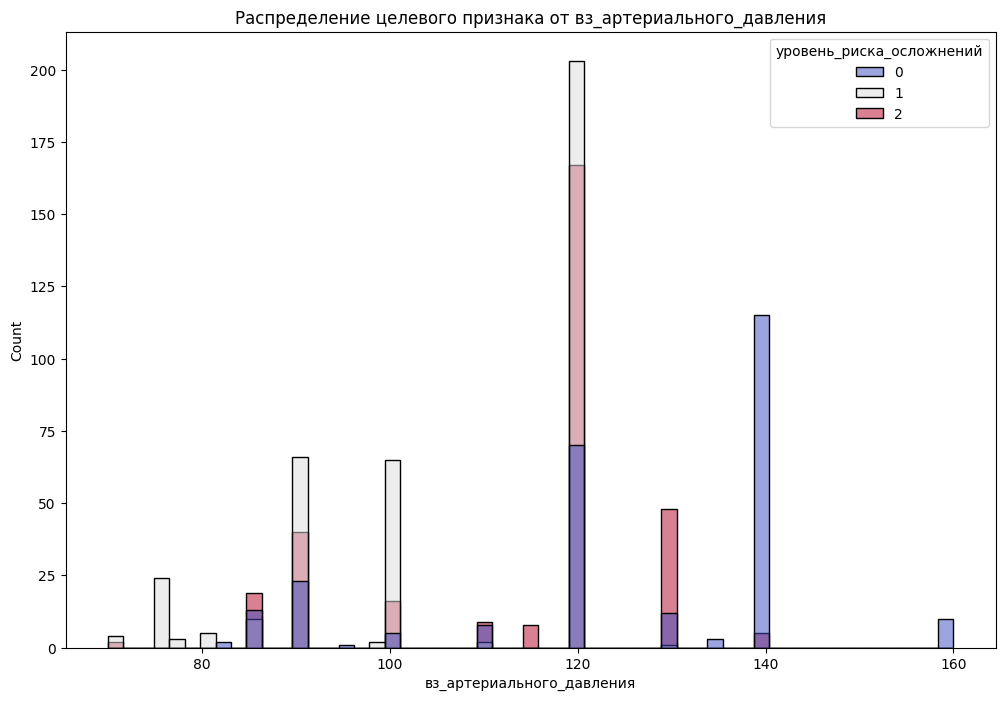

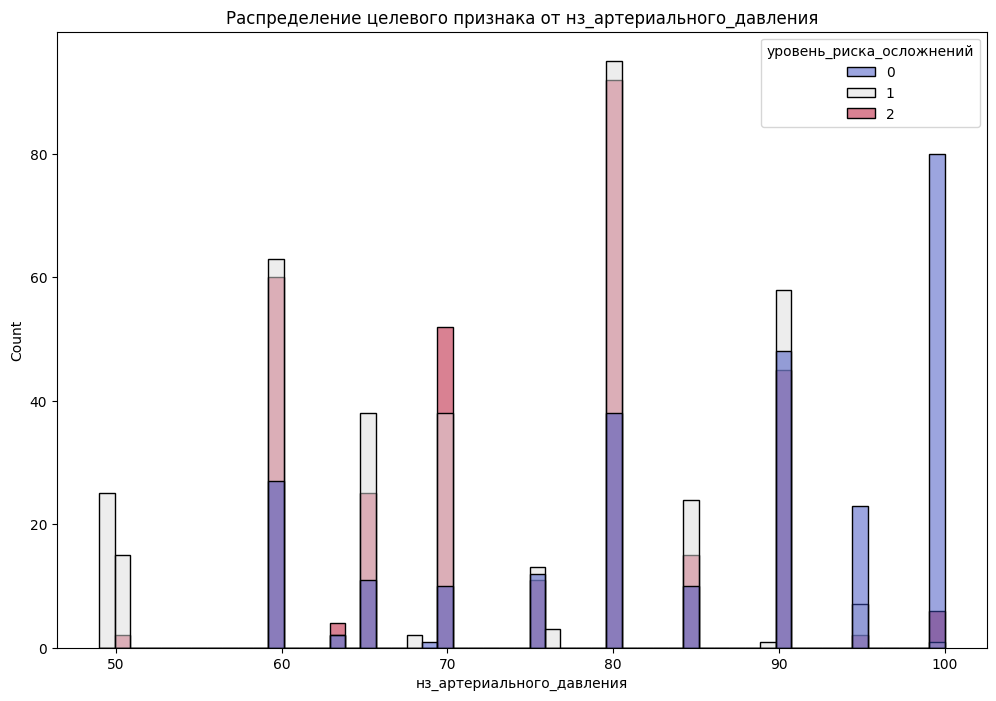

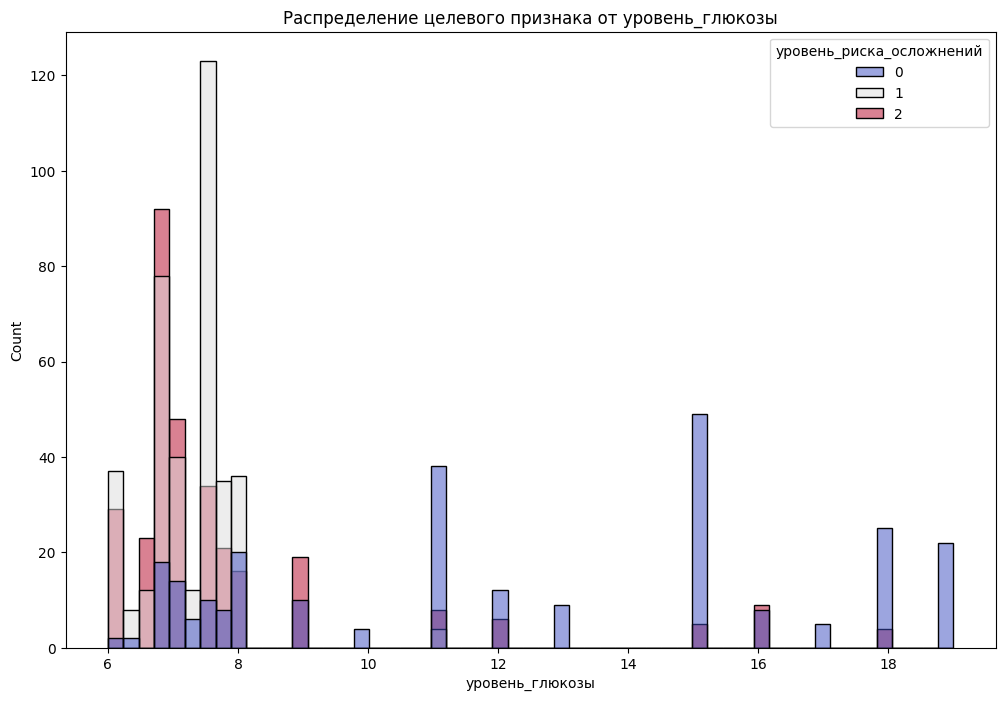

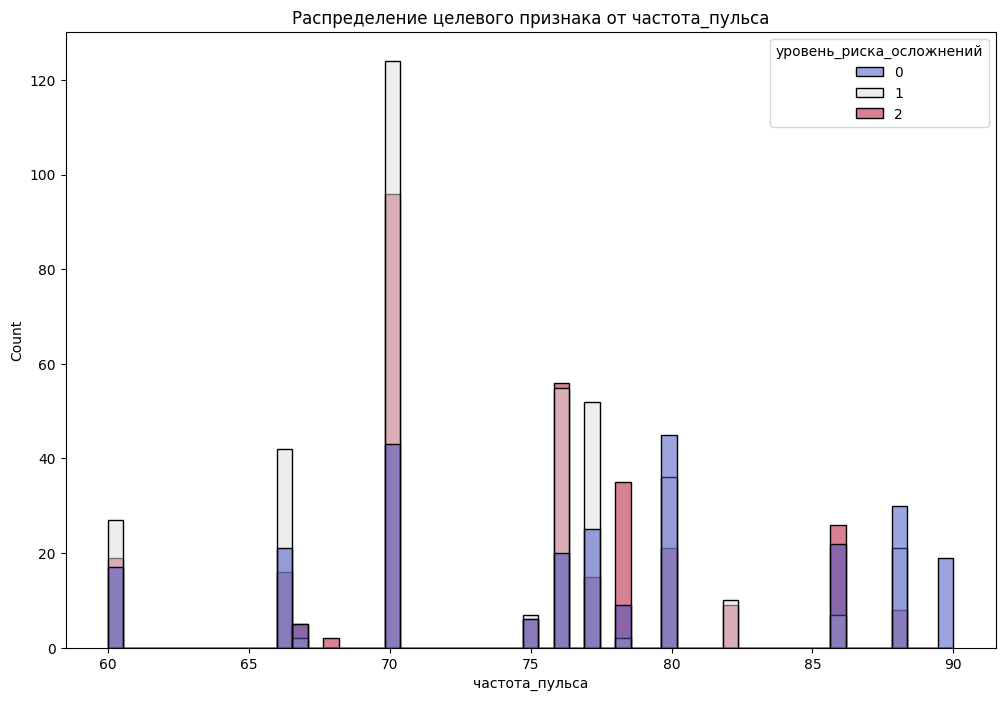

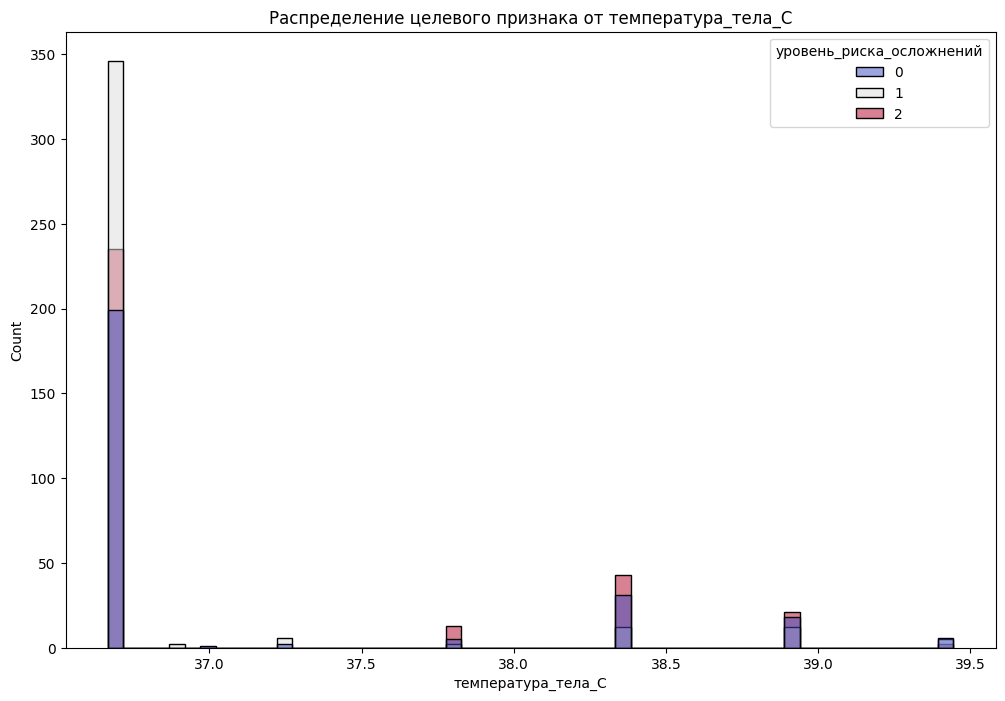

In [69]:
numeric_features = ['Возраст',	'вз_артериального_давления',	'нз_артериального_давления',\
                    'уровень_глюкозы',	'частота_пульса',	'температура_тела_C']  # Здесь числовые признаки
for feature in numeric_features:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=feature, hue="уровень_риска_осложнений",palette="coolwarm",bins=55)
    plt.title(f"Распределение целевого признака от {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

# 1 - низкий уровень риска
# 0 - высокий уровень риска
# 2 - средний уровень риска

## Выводы:

**1. Влияние признака Возраст на целевой признак**:
* Возрастной категория от 15 до 24 лет больше характерно:

Минимальные риски и средние риски осложнений при беременности, однако можем заметить что в возрасте 17 лет у немалого количества респодентов есть высокие риски осложнения.

* Возрастная категория от 25 до 31 лет в основном характеризуется средними рисками осложнения

* Возрастная категория от 32 и выше подвержена высокими рискам осложения



**2. Влияние вз_артериального давления (систолическое давление) на целевой признак** :

* Исходя из графика можно сказать, что показатели систолическго давления от 70 до 120 мм ртутного столба имеют низкие риски осложнений.

* Давлнеие в районе 128-135 мм имеют преимущественно средние риские осложнений

* Показатели выше 138 мм ртутного столба иммеют высокие риски осложениния при беременности

**3. Влияние нз_артериального_давления (диастолическое давление ) на целевой признак** :

* Показатель диастолического давления от 50 до 90 мм ртутного столбца имеют смешаные риски с преобладанием низких рисков и средних рисков осложнения.
* показатели выше 94 мм ртутного столбца стабильно сопровождаются высокими рисками осложнения;

**4. Влияние уровня глюкозы на целевой признак** :

* Показатели глюкозы от 6 до 8 имеют смешаные риски с преобладанием в первую очередь низких рисков и затем средних рисков осложнения.
* Показатели глюкозы от 9 до 20 имеют стабильно высокие риски осложнения;

**5. Влияние частоты пульса на целевой признак** :

* Частота пульса от 60 до 78 имеют смешаные риски с преобладанием в первую очередь низких рисков и затем средних рисков осложнения.
* Показатели частоты пульса от 79 до 90 имеют высокие риски осложнения;

**6. Влияние температуры тела в цельсиях на целевой признак**:

* Исходя из графика видно, что уровень температуры не оказывает сильного воздействия на риски.
Однако, при норме 36.6 градусов температуры тела, порядка 200 имеют высокие риски осложнения, около 230 женщин средние риски и порядка 350 женщин низкие риски осложнения.


In [80]:
target_test.sort_values().value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


уровень_риска_осложнений
1    100
2     76
0     65
Name: count, dtype: int64

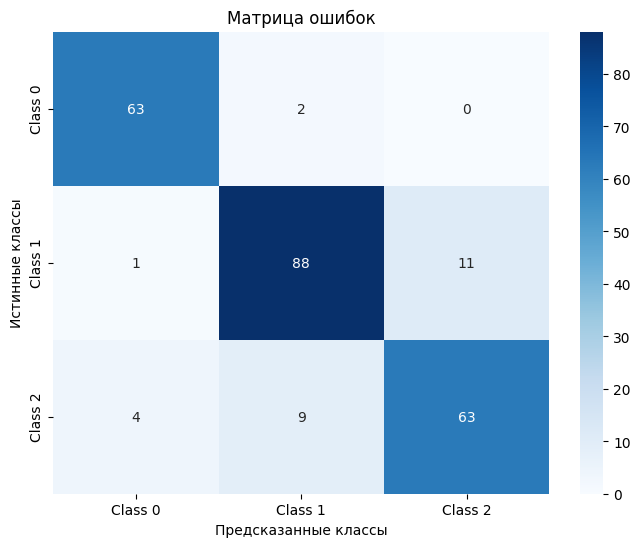

In [75]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(target_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',\
            xticklabels=['Class 0', 'Class 1', 'Class 2'], \
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

#Вывод по построенной матрице ошибок:

- Class 0 (высокий уровень риска) - 63, т.е модель хорошо предсказывает женщин, которые находятся в высокой зоне риска. Лишь двух она отнесла к Классу 1, которые относятся к людям с низким риском осложнений. **Правильных ответов 63 из 65 (97%)**;

- Class 1  - 88, т.е модель предсказала женщин которые имюет низкие риски осложнений. Но при этом модель 11 респондентов отнесла к классу 2, с средним уровнем риска, что не удивительно, так как показатели среднего и низкого уровня рисков очень схожи. **Правильных ответов - 88 из 100 (88%)**;

- Class 2 - 63, т.е модель предсказала женщин которые имюет средний уровень осложнений. При этом в 13 случаях она ошиблась, 9 из них она отнесла к низкому уровню риска и 4 респодентов к высокому уровню риска. **Правильных ответов - 63 из 76 (83%)**.


# Подведем итог:

Низкий уровень риска характеризуется следующими показателями:

1. Возрастная категория от 15 до 24 лет;
2. Показатели систолическго давления от 70 до 120 мм ртутного столба;
3. Показатель диастолического давления от 50 до 90 мм ртутного столба;
4. Показатели глюкозы от 6 до 8;
5. Частота пульса от 60 до 78.

Средний уровень риска имеет следующие показатели:

1. Возрастная категория от 25 до 31 лет;
2. Показатели систолическго давления от 128-135 мм рт. столба;
3. Показатель диастолического давления от 50 до 90 мм ртутного столба;
4. Показатели глюкозы от 6 до 8;
5. Частота пульса от 60 до 78.

Высокий уровень риска осложнений имеет следующие показатели:

1. Возрастная категория от 32 и выше;
2. Показатели систолическго давления выше 138 мм ртутного столба;
3. Показатель диастолического давления выше 94 мм ртутного столба;
4. Показатели глюкозы от 9 до 20;
5. Частота пульса от 79 до 90.




